# Failover Analysis
Plots iperf performance during controller-directed failover

In [693]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [2]:
import json
import os
import numpy as np
import pandas as pd
from glob import glob

DIV = 1e9

def lenient_read_json(file):
    '''Sometimes the json files output by iperf3 have one error message at the top.
    This function discards that error message and parses the rest of the file'''
    try:
        return json.load(open(file))
    except Exception as e:
        print("Malformed json {}: {}".format(file, e))
        lines = '\n'.join(open(file).readlines()[1:])
        return json.loads(lines)

Different iperf sessions might start at slightly different times. To fix this, the iperf sessions are aligned with one another using a timestamp output by the server when the client successfully connects.

In [1403]:
from collections import namedtuple

Losses = namedtuple('losses', ['time', 'num', 'den', 'i'])

def read_iperf_losses(directory):
    # Read the Shremote log file to get the time at which the client connected
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        client_entry= [e for e in event_log if e['name_'] == 'iperf_client'][0]
        iperf_time= client_entry['time_']
    except IOError:
        print("{} Event log not found".format(directory))
        return None
    
    # For each server output, get the time at which the client successfully connected
    server_files = glob(os.path.join(directory,'iperf','server_*.out'))
    starts = {}
    losses = []
    got_some = False
    for i, server_file in enumerate(server_files):
        server_losses = []
        started = False
        num = int(server_file.split('_')[-1][:-4])
        for line in open(server_file):
            if '0.00-' in line:
                started = True
            if started and line.strip().endswith('-'):
                break
                
            if started:
                server_loss_part = line.split()[-2]
                num = int(server_loss_part.split('/')[0])
                den = int(server_loss_part.split('/')[1])
                if den > 0:
                    t = (float(line.split()[0]))
                    server_losses.append(Losses(t, num, den, i))
        else:
            print("Could not find 0.00- in {}".format(server_file))
           
        newdf = pd.DataFrame(server_losses)
#         newdf['time'] -= drop_time
        losses.append(newdf)
        
    df = pd.concat(losses, ignore_index=True)
    df = df.assign(time = df.time - iperf_time)
    df = df.assign(epoch=(df.time * 10).apply(np.ceil) / 10)
    df = df.groupby('epoch')[['num', 'den']].sum().reset_index()
    df['value'] = df['num'] / df['den']
    
# #     df = df.assign(epoch = df.epoch)
#     df = df.groupby('epoch')['value'].median().reset_index()
    return df.rename(columns=dict(epoch='time'))
        
        
def read_iperf_feature(directory, feature='bits_per_second'):
    # Read the Shremote log file to get the time at which the client connected
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        client_entry= [e for e in event_log if e['name_'] == 'iperf_client'][0]
        iperf_time= client_entry['time']
    except IOError:
        print("{} Event log not found".format(directory))
        return None
    
    # For each server output, get the time at which the client successfully connected
    server_files = glob(os.path.join(directory,'iperf','server_*.out'))
    starts = {}
    if feature == 'loss':
        losses = {}
    for server_file in server_files:
        server_losses = []
        started = False
        num = int(server_file.split('_')[-1][:-4])
        for line in open(server_file):
            if '0.00-' in line:
                started = True
                starts[num] = (float(line.split()[0]))
                

            if feature == 'loss' and started:
                server_loss_part = line.split()[-2]
                num = int(server_loss_part.split('/')[0])
                den = int(server_loss_part.split('/')[1])
                pct = num / den
                
                t = lime.split()[3].split('-')[0]
                server_losses.append(Losses(t, num))
            
        else:
            print("Could not find Accepted connection in {}".format(server_file))
           
    # The amount of usable time in the experiments is that for which
    # all of the clients were running simultaneously
    min_start = min(starts.values())
    max_start = max(starts.values())
    usable_time = iperf_time - (max_start - min_start)
            
    client_base = os.path.join(directory, 'iperf', 'client_%d.json')
    
    per_client_bps = []
    
    # Read each client file and extract the throughputs during the usable interval
    for i, start in starts.items():
        offset = max_start - start
        if offset > 0:
            print("Offset of file %d is %f" % (i, offset))
        client_bps = []
        client_file = client_base % i
        client = lenient_read_json(client_file)
        for interval in client['intervals']:
            interval = interval['streams'][0]
            if interval['end'] >= offset and interval['end'] < (usable_time + offset):
                client_bps.append(interval[feature])
        
        if len(client_bps) > 0:
            per_client_bps.append(client_bps)
        
    # Lengths might differ by 1 due to rounding errors.
    # Take the smallest timeseries and truncate all to that length
    minlen = min([len(b) for b in per_client_bps])
    per_client_bps = [bps[:minlen] for bps in per_client_bps]    
        
    # Sum the results
    all_bps = np.array(per_client_bps)
    if feature == 'rtt':
        summed_bps = all_bps.mean(axis=0)
    else:
        summed_bps = all_bps.sum(axis=0)
    timestamps = np.arange(0, len(summed_bps) / 10, .1)
    return pd.DataFrame({'time': timestamps, 'value': summed_bps})

In [1400]:
df100 = read_iperf_losses('../failover_output_5/fec/fec_udp_failover_100/fec_udp_failover_100_1')
df50 = read_iperf_losses('../failover_output_5/fec/fec_udp_failover_050/fec_udp_failover_050_1')
df10 = read_iperf_losses('../failover_output_5/fec/fec_udp_failover_010/fec_udp_failover_010_3')
df001 = read_iperf_losses('../failover_output_5/fec/fec_udp_failover_001/fec_udp_failover_001_1')


<IPython.core.display.Javascript object>


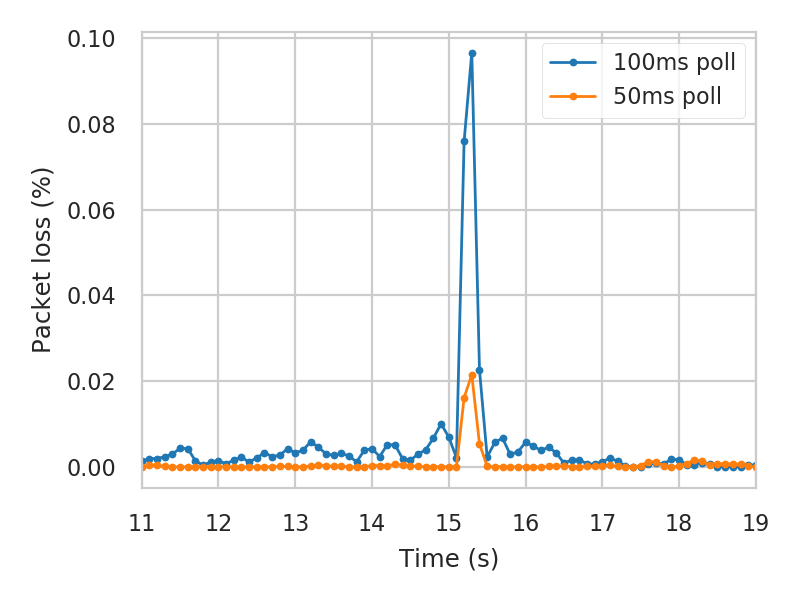

In [1312]:
plt.figure(figsize=(4, 3))
# plt.plot(df100.time, df100.value, '.-', linewidth=1)
def plot_rolling_loss(df):
    df = df.rolling(2, on='time').sum()
    df = df[(df.time > 5)]
    plt.plot(df.time, df.value, '.-', linewidth=1)
    return df
# plot_rolling_loss(df100)
# plot_rolling_loss(df50)
plot_rolling_loss(df10)
x = plot_rolling_loss(df001)


plt.xlim([11, 19])
plt.ylabel("Packet loss (%)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.legend(["100ms poll", "50ms poll", "10ms poll", '1ms poll'])


## Data Aggregation
Reads a series of experiments located in the same base directory

In [972]:
def read_iperf_experiments(base_dir, experiments, labels, feature='bits_per_second'):
    data = []
    for exp in experiments:
        for label in labels:
            df = read_iperf_feature(os.path.join(base_dir, exp, '%s_%s' % (exp, label)), feature)
            df.value /= 1e6
            data.append(df.assign(experiment=exp, trial=label))
    return pd.concat(data, ignore_index=True)

def read_iperf_experiment_losses(base_dir, experiments, labels):
    data = []
    for exp in experiments:
        for label in labels:
            df = read_iperf_losses(os.path.join(base_dir, exp, '%s_%s' % (exp, label)))
            data.append(df.assign(experiment=exp, trial=label))
    return pd.concat(data, ignore_index=True)

In [1404]:

udp_exps = ['fec_udp_failover_%s' % x for x in ('020', '010', '001')]
failover_losses = read_iperf_experiment_losses('../failover_output_6/fec', udp_exps, [1,2, 3, 4, 5])
failover_power = pickle.load(open('fec_failover_powers.pickle', 'rb'))


# fl_ls = failover_losses[failover_]

### Sample data plotting
plotting some sample data from the experiments for quick validation of expectations

In [1394]:
import matplotlib.pyplot as plt

def plot_fill_experiment(df, roll=None, color=None, mult=1e-3, **kwargs):
    handles = []
    df = df.assign(value = df.value * mult)
#     df = df.assign(time = df.time+1)
#     df = df[(df.time > 10) & (df.time < 20) ]
#     df = df[df.experiment == experiment]
    if roll:
        df = df.rolling(int(roll * 10), on='time')[['time', 'value']].mean()
    grouped = df.groupby('time')[['value']]
    gmin = grouped.min()
    gmax = grouped.max()
    gmean = grouped.median().reset_index()
    h = plt.fill_between(gmean.time, gmin.value, gmax.value, alpha=.2, color=color)
    h2 = plt.plot(gmean.time, gmean.value, '.-', color=color, alpha=1, linewidth=1, **kwargs)
    plt.xlabel('')
    return h2


# Plot showing iperf loss only

<IPython.core.display.Javascript object>


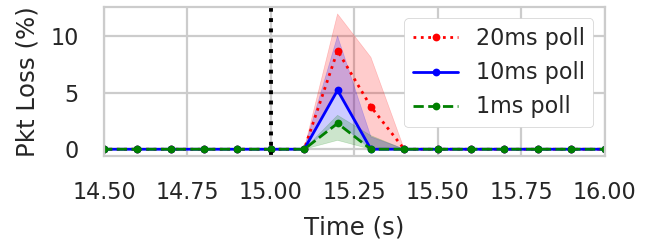

In [1538]:

def plot_loss_only(iperf):
    df = iperf.assign(time = iperf.time)
    handles = []
    for col, ls, interval in zip(['r', 'b', 'g', 'orange'], [':', '-', '--', 'dashdot'], ['020', '010', '001']):
        exp = 'fec_udp_failover_%s' % interval
        df2 = df[df.experiment == exp]
        df2 = df2.assign(value=df2.value * 100)
        handles.extend(plot_fill_experiment(df2, roll=0, label=interval, color=col, ls=ls, mult=1))


#     plt.xlim([-1, 1])
    plt.xlim([14.5, 16])
    # # rolled = hc_failover.roll(10, on='time')[['time', 'value']].mean()
    # plt.plot(hc_failover.time, hc_failover.value)
    # plt.plot(fec_failover.time, fec_failover.value)
    # plot_fill_experiment(hc_failover, 'failover', roll=0, color='b')

    plt.axvline(15, ls=':', color='k')
    plt.ylabel("Pkt Loss (%)")
    plt.xlabel("Time (s)")
    plt.legend(handles, ['20ms poll', '10ms poll', '1ms poll'], loc='upper right', fancybox=True, framealpha=1)

    plt.tight_layout()
    plt.subplots_adjust(right=.93, bottom=.35, left=.16, top=.97)
    plt.savefig('failover_without_power.pdf')

plt.figure(figsize=(3.25, 1.2))    
plot_loss_only(failover_losses)

In [1346]:
def plot_powers(powers, axs, color=None, **kwargs):
    devices = ['fpga12/1', 'fpga12/0']
#     devices = ['tofino', 'fpga12/1', 'fpga12/0']
#     powers = powers[(powers.exp_time > 5) & (powers.exp_time < 35)]
    powers = powers.assign(exp_time = powers.exp_time)
    for ax, dev in zip(axs, devices):
        plt.sca(ax)
#         ax.axvline(12+5, color='gray')
#         ax.axvline(18+5, color='gray')
        
        df = powers[powers.device == dev].copy()
        df.exp_time = df.exp_time.round()
        
#         df = df.groupby(['exp_time', 'trial']).mean().reset_index()
        grouped = df.groupby('exp_time')
        
        gmin = grouped.min()
        gmax = grouped.max()
        gmean = grouped.mean().reset_index()
#         return gmean
        
        h = plt.fill_between(gmean.exp_time, gmin.power, gmax.power, alpha=.2, facecolor=color)
        plt.plot(gmean.exp_time, gmean.power, color=color, alpha=1, linewidth=1, **kwargs)


In [1412]:
def make_zoomy(ax):
    color = [.1, .1, .1]
    
    lims = ax.get_xlim()
#     start_x = (12.2 - lims[0])/ (lims[1] - lims[0])
    start_x2 = (14 - lims[0])/ (lims[1] - lims[0])
    
#     end_x = (17.8 - lims[0]) / (lims[1] - lims[0])
    end_x2 = (17 - lims[0]) / (lims[1] - lims[0])
    
    arrowprops=dict(color=color, headlength=0.1, headwidth=0, width=.1)
    
    ax.annotate('', xy=(start_x2, 1),  xycoords='axes fraction',
            xytext=(0, 1.64), textcoords='axes fraction',
            arrowprops=arrowprops,
            horizontalalignment='right', verticalalignment='top',
            )
    plt.gcf().texts.append(ax.texts.pop())
    
    ax.annotate('', xy=(end_x2, 1),  xycoords='axes fraction',
        xytext=(1., 1.64), textcoords='axes fraction',
        arrowprops=arrowprops,
        horizontalalignment='right', verticalalignment='top',
        )
    plt.gcf().texts.append(ax.texts.pop())
    
    ax.annotate('', xy=(end_x2, 1.),  xycoords='axes fraction',
        xytext=(end_x2, -1.1), textcoords='axes fraction',
        arrowprops=arrowprops,
        horizontalalignment='right', verticalalignment='top',
        zorder=100
    )
    
    plt.gcf().texts.append(ax.texts.pop())
    
    ax.annotate('', xy=(start_x2, 1.),  xycoords='axes fraction',
        xytext=(start_x2, -1.1), textcoords='axes fraction',
        arrowprops=arrowprops,
        horizontalalignment='right', verticalalignment='top',
        zorder=100
    )
    
    plt.gcf().texts.append(ax.texts.pop())

In [1356]:
%matplotlib notebook

def plot_failover(iperf, power):

    gridspec = dict(hspace=.1, height_ratios=[2.5, .45, 1, 1])
    fig, axs = plt.subplots(nrows=4, ncols=1, gridspec_kw=gridspec, figsize=(4.5, 3.5))
    axs[1].set_visible(False)

    plt.sca(axs[0])

    handles = []
    for i, col, ls, interval in zip([1,2,3], ['r', 'b', 'g', 'orange'], [':', '-', '--'], ['020', '010', '001']):
        exp = 'hc_failover_%s' % interval
        df = iperf[iperf.experiment == exp]
        handles.extend(plot_fill_experiment(df, roll=0, label=interval, color=col, ls=ls, zorder=i))
    axs[0].set_ylim([0, 10])
    axs[0].set_xlim([12, 18])
    axs[0].set_xticks([12, 13, 14, 15, 16, 17])
    axs[0].set_xticklabels(['', 13, 14, 15, 16, 17])

    # # rolled = hc_failover.roll(10, on='time')[['time', 'value']].mean()
    # plt.plot(hc_failover.time, hc_failover.value)
    # plt.plot(fec_failover.time, fec_failover.value)
    # plot_fill_experiment(hc_failover, 'failover', roll=0, color='b')

    plt.axvline(14.9, ls='--', color='k')
    plt.ylabel("Throughput\n(Gbps)")
    # plt.xlabel("Time (s)")

    for col, ls, interval in zip(['r', 'b', 'g', 'orange'], [':', '-', '--'], ['05', '01', '001']):
        exp = 'hc_failover_%s' % interval
        df = failover_power[power.experiment == exp]
        plot_powers(df, axs[2:], color=col, ls=ls)

#     axs[2].set_ylim([110.5, 112])

#     for ax in axs[2:4]:
    axs[2].set_xticklabels([])

    for ax in axs[2:]:
        ax.axvline(14.9, ls='--', color='k', linewidth=1)
        ax.set_xlim([0, 30])

    axs[3].set_ylabel("Power (W)")
    plt.subplots_adjust(left=.15, right=.86, bottom=.12)
    make_zoomy(axs[2])
#     axs[2].text(30.5, np.mean(axs[2].get_ylim()), 'P.ASIC', horizontalalignment='left', verticalalignment='center', fontsize=9)
    axs[2].text(30.5, np.mean(axs[2].get_ylim()), 'Primary\nFPGA', horizontalalignment='left', verticalalignment='center', fontsize=9)
    axs[3].text(30.5, np.mean(axs[3].get_ylim()), 'Failover\nFPGA', horizontalalignment='left', verticalalignment='center', fontsize=9)
    axs[0].legend(handles=handles, labels=['50ms poll', '10ms poll', '1ms poll'], loc='lower right', bbox_to_anchor=(1, 1), ncol=3)
    axs[3].set_xlabel("Time (s)")


In [1518]:
%matplotlib notebook

def plot_failover_loss(iperf, power, exp_template = 'fec_udp_failover_%s'):

#     gridspec = dict(hspace=.1, height_ratios=[2.5, .45, 1, 1, 1])
    gridspec = dict(hspace=.1, height_ratios=[2, .45, 1, 1])
    fig, axs = plt.subplots(nrows=4, ncols=1, gridspec_kw=gridspec, figsize=(3.66, 2.3))
#     fig, axs = plt.subplots(nrows=5, ncols=1, gridspec_kw=gridspec, figsize=(4.5, 3.5))
    axs[1].set_visible(False)

    plt.sca(axs[0])

    poll_times = ['020', '010', '001']
    
    handles = []
    for i, col, ls, interval in zip([1,2,3], ['r', 'b', 'g', 'orange'], [':', '-', '--', 'dashdot'], poll_times):
        exp = exp_template % interval
        df = iperf[iperf.experiment == exp]
        df= df.assign(value = df.value* 100)
        handles.extend(plot_fill_experiment(df, roll=0, label=interval, color=col, ls=ls, zorder=i, mult=1))
    axs[0].set_xlim([14, 17])
#     axs[0].set_ylim([18, None])
    axs[0].set_xticks([14, 15, 16, 17])
    axs[0].set_xticklabels([14, 15, 16, 17])
    axs[0].tick_params(pad=3)

    # # rolled = hc_failover.roll(10, on='time')[['time', 'value']].mean()
    # plt.plot(hc_failover.time, hc_failover.value)
    # plt.plot(fec_failover.time, fec_failover.value)
    # plot_fill_experiment(hc_failover, 'failover', roll=0, color='b')

    plt.axvline(15, ls='--', color='k')
    plt.ylabel("Pkt Loss (%)")
    # plt.xlabel("Time (s)")

#     for col, ls, interval in zip(['r', 'b', 'g', 'orange'], [':', '-', '--'], poll_times):
#         exp = exp_template % interval
#         df = failover_power[power.experiment == exp]
    plot_powers(failover_power, axs[2:], color='k', ls='-')

#     axs[2].set_ylim([110.5, 112])

    axs[2].set_xticklabels([])

    for ax in axs[2:]:
        ax.axvline(15, ls='--', color='k', linewidth=1)
        ax.set_xlim([0, 30])
        ax.tick_params(pad=3)

    axs[2].set_ylim([27.05, 27.35])  
    axs[2].set_yticks([27.1, 27.3])
    axs[3].set_ylim([24.55, 24.85])    
        
    plt.subplots_adjust(left=.18, right=.8, bottom=.17)
    make_zoomy(axs[2])
    fig.text(0.04, 0.32, 'Power (W)', ha='center', va='center', rotation='vertical', fontsize=9)
    
#     axs[2].text(30.5, np.mean(axs[2].get_ylim()), 'P.ASIC', horizontalalignment='left', verticalalignment='center', fontsize=9)
    axs[2].text(30.5, np.mean(axs[2].get_ylim()), 'Primary\nFPGA', horizontalalignment='left', verticalalignment='center', fontsize=9)
    axs[3].text(30.5, np.mean(axs[3].get_ylim()), 'Failover\nFPGA', horizontalalignment='left', verticalalignment='center', fontsize=9)
    labels = ['%dms poll' % int(x) for x in poll_times]
    axs[0].legend(handles=handles, labels=labels, loc='lower right', bbox_to_anchor=(1.25, 1), ncol=3)
    axs[3].set_xlabel("Time (s)")


# Unused plot
Version of plot that also shows power, not used in final experiment

<IPython.core.display.Javascript object>


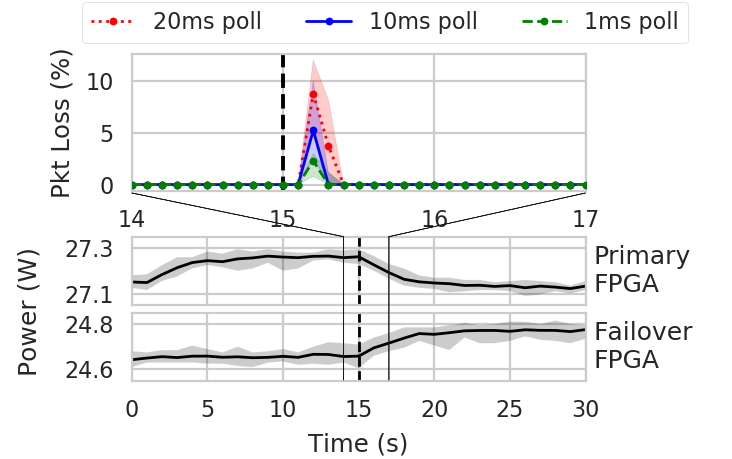

In [1519]:
plot_failover_loss(failover_losses, failover_power)
plt.savefig("failover_with_power.pdf")